In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

# Load and preprocess data
data = pd.read_csv('Google_Stock_Price_Train.csv')

# Parse dates and filter data from April 1, 2014
data['Date'] = pd.to_datetime(data['Date'])  
data = data[data['Date'] >= '2014-04-01']    

# Select relevant columns
data = data[['Open', 'High', 'Low', 'Volume', 'Close']]  

# Convert columns to numeric by removing commas (if present)
data = data.replace({',': ''}, regex=True).astype(float)

# Step 2: Scale data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Step 3: Create sequences for model input and output
N = 30  # Number of past days to use
M = 1   # Number of future days to predict
X = []
y = []
for i in range(N, len(scaled_data) - M + 1):
    X.append(scaled_data[i - N:i])     # N days input
    y.append(scaled_data[i:i + M, 0])  # M days output, using 'Open' price

X, y = np.array(X), np.array(y)

# Step 4: Split data into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)


In [2]:
# Load and preprocess the test data
test_data = pd.read_csv('Google_Stock_Price_Test.csv')

# Parse dates and filter data from April 1, 2014
test_data['Date'] = pd.to_datetime(test_data['Date'])  
test_data = test_data[test_data['Date'] >= '2014-04-01']  

# Select relevant columns
test_data = test_data[['Open', 'High', 'Low', 'Volume', 'Close']]  

# Convert columns to numeric by removing commas 
test_data = test_data.replace({',': ''}, regex=True).astype(float)

# Scale the test data using the same scaler fitted on the training data
scaled_test_data = scaler.transform(test_data)


# Define smaller values for N and M since we have limited test data
N = 5  # Reduce N to match the available data
M = 1  # Predict just one day ahead

# Create sequences for the small test dataset
X_test, y_test = [], []
for i in range(N, len(scaled_test_data)):
    X_test.append(scaled_test_data[i - N:i])   
    y_test.append(scaled_test_data[i:i + M, 0])  

X_test, y_test = np.array(X_test), np.array(y_test)


Epoch 1/200


2024-11-30 14:58:56.363249: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


17/17 [==============================] - 1s 14ms/step - loss: 0.2477 - val_loss: 0.0909
Epoch 2/200
17/17 [==============================] - 0s 5ms/step - loss: 0.1395 - val_loss: 0.0267
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 0.1056 - val_loss: 0.0045
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0681 - val_loss: 0.0031
Epoch 5/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0576 - val_loss: 0.0052
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0531 - val_loss: 0.0084
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0393 - val_loss: 0.0049
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0314 - val_loss: 0.0063
Epoch 9/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0334 - val_loss: 0.0052
Epoch 10/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0255 - val_loss: 0.0031
Epoch 11/200
17/17 [

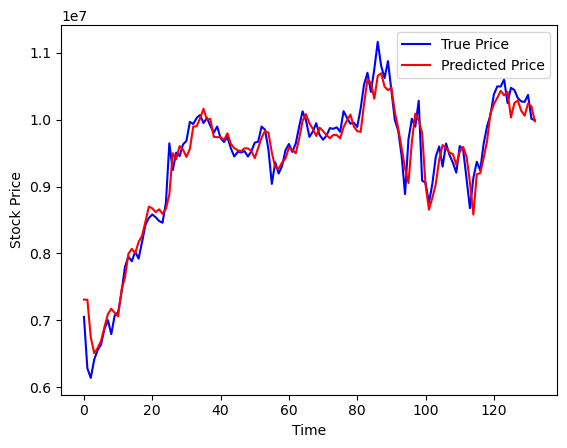

Directional Accuracy (DA) on Validation Set: 57.58%


In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from matplotlib import pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.callbacks import EarlyStopping

#Initial Model
# Build the vanilla RNN model
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=M))  

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Create an EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)


# Train the model
history = model.fit(X_train, y_train, 
                    epochs=200, batch_size=32, 
                    validation_data=(X_val, y_val), 
                    callbacks=[early_stopping]
                    )

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  #

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
17/17 [==============================] - 1s 13ms/step - loss: 0.4374 - mae: 0.5048 - val_loss: 0.0154 - val_mae: 0.0936
Epoch 2/200
17/17 [==============================] - 0s 5ms/step - loss: 0.1748 - mae: 0.3313 - val_loss: 0.0073 - val_mae: 0.0702
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0944 - mae: 0.2470 - val_loss: 0.0046 - val_mae: 0.0506
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0825 - mae: 0.2216 - val_loss: 0.0138 - val_mae: 0.1041
Epoch 5/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0729 - mae: 0.2096 - val_loss: 0.0036 - val_mae: 0.0468
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0610 - mae: 0.1878 - val_loss: 0.0030 - val_mae: 0.0414
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0497 - mae: 0.1704 - val_loss: 0.0046 - val_mae: 0.0512
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0399 - 

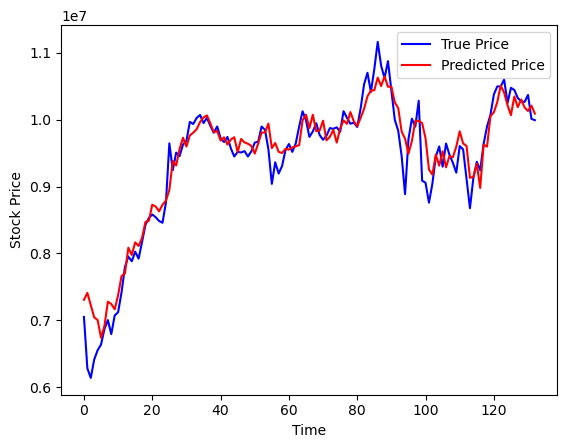

Directional Accuracy (DA) on Validation Set: 58.33%


In [4]:
# Model 2
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M))  


model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])


early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)


# Train the model
history = model.fit(X_train, y_train, epochs=200,
                    batch_size=32, validation_data=(X_val, y_val), 
                    callbacks= [early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
17/17 [==============================] - 1s 18ms/step - loss: 0.6561 - mae: 0.6401 - val_loss: 0.0399 - val_mae: 0.1958
Epoch 2/200
17/17 [==============================] - 0s 8ms/step - loss: 0.4984 - mae: 0.5727 - val_loss: 0.0824 - val_mae: 0.2844
Epoch 3/200
17/17 [==============================] - 0s 8ms/step - loss: 0.3719 - mae: 0.4879 - val_loss: 0.0316 - val_mae: 0.1742
Epoch 4/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2822 - mae: 0.4159 - val_loss: 0.0300 - val_mae: 0.1687
Epoch 5/200
17/17 [==============================] - 0s 7ms/step - loss: 0.2507 - mae: 0.3931 - val_loss: 0.0086 - val_mae: 0.0853
Epoch 6/200
17/17 [==============================] - 0s 9ms/step - loss: 0.2153 - mae: 0.3677 - val_loss: 0.0063 - val_mae: 0.0601
Epoch 7/200
17/17 [==============================] - 0s 8ms/step - loss: 0.1970 - mae: 0.3483 - val_loss: 0.0358 - val_mae: 0.1867
Epoch 8/200
17/17 [==============================] - 0s 9ms/step - loss: 0.1472 - 

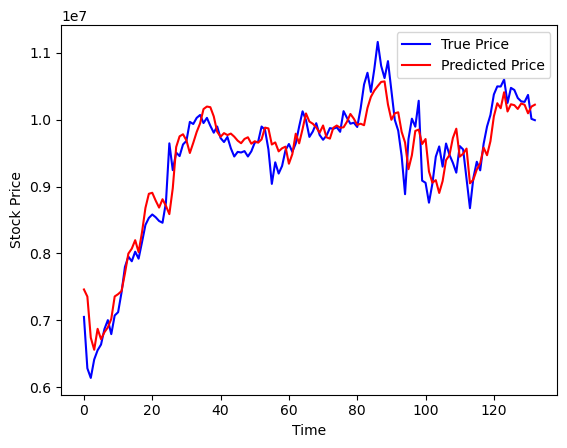

Directional Accuracy (DA) on Validation Set: 54.55%


In [5]:
# Model 3
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=32, validation_data=(X_val, y_val), 
                    callbacks = [early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  
# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
17/17 [==============================] - 1s 18ms/step - loss: 1.0921 - mae: 0.8415 - val_loss: 0.0074 - val_mae: 0.0717
Epoch 2/200
17/17 [==============================] - 0s 8ms/step - loss: 0.8281 - mae: 0.7231 - val_loss: 0.1339 - val_mae: 0.3630
Epoch 3/200
17/17 [==============================] - 0s 8ms/step - loss: 0.5900 - mae: 0.6147 - val_loss: 0.1347 - val_mae: 0.3589
Epoch 4/200
17/17 [==============================] - 0s 8ms/step - loss: 0.5854 - mae: 0.6042 - val_loss: 0.0217 - val_mae: 0.1320
Epoch 5/200
17/17 [==============================] - 0s 8ms/step - loss: 0.4590 - mae: 0.5443 - val_loss: 0.0294 - val_mae: 0.1605
Epoch 6/200
17/17 [==============================] - 0s 8ms/step - loss: 0.4624 - mae: 0.5396 - val_loss: 0.1178 - val_mae: 0.3386
Epoch 7/200
17/17 [==============================] - 0s 9ms/step - loss: 0.3625 - mae: 0.4938 - val_loss: 0.0021 - val_mae: 0.0332
Epoch 8/200
17/17 [==============================] - 0s 10ms/step - loss: 0.3303 -

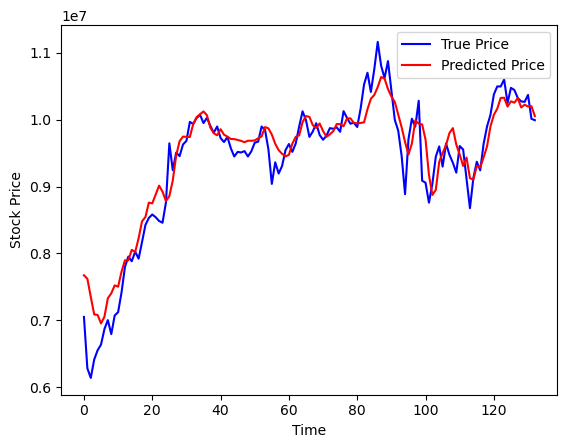

Directional Accuracy (DA) on Validation Set: 54.55%


In [6]:
# Model 4
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=True))
model.add(Dropout(0.4))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
17/17 [==============================] - 1s 13ms/step - loss: 0.9563 - mae: 0.7560 - val_loss: 0.0157 - val_mae: 0.1092
Epoch 2/200
17/17 [==============================] - 0s 5ms/step - loss: 0.5894 - mae: 0.6119 - val_loss: 0.1141 - val_mae: 0.3330
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 0.4285 - mae: 0.4978 - val_loss: 0.0363 - val_mae: 0.1806
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.2822 - mae: 0.4249 - val_loss: 0.0031 - val_mae: 0.0425
Epoch 5/200
17/17 [==============================] - 0s 5ms/step - loss: 0.2595 - mae: 0.3980 - val_loss: 0.0117 - val_mae: 0.0949
Epoch 6/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1996 - mae: 0.3473 - val_loss: 0.0020 - val_mae: 0.0334
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1650 - mae: 0.3061 - val_loss: 0.0084 - val_mae: 0.0818
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.1555 - 

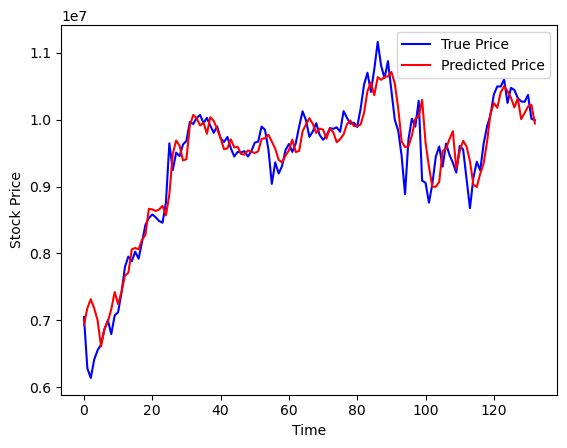

Directional Accuracy (DA) on Validation Set: 52.27%


In [7]:
# Model 5
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.5))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.5))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")
# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")


Epoch 1/200
17/17 [==============================] - 1s 13ms/step - loss: 0.3170 - mae: 0.4401 - val_loss: 0.1279 - val_mae: 0.3492
Epoch 2/200
17/17 [==============================] - 0s 5ms/step - loss: 0.1879 - mae: 0.3285 - val_loss: 0.0168 - val_mae: 0.1189
Epoch 3/200
17/17 [==============================] - 0s 5ms/step - loss: 0.1438 - mae: 0.2988 - val_loss: 0.0056 - val_mae: 0.0653
Epoch 4/200
17/17 [==============================] - 0s 5ms/step - loss: 0.1235 - mae: 0.2670 - val_loss: 0.0034 - val_mae: 0.0493
Epoch 5/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0866 - mae: 0.2223 - val_loss: 0.0018 - val_mae: 0.0311
Epoch 6/200
17/17 [==============================] - 0s 5ms/step - loss: 0.0709 - mae: 0.2031 - val_loss: 0.0058 - val_mae: 0.0654
Epoch 7/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0614 - mae: 0.1827 - val_loss: 0.0032 - val_mae: 0.0504
Epoch 8/200
17/17 [==============================] - 0s 6ms/step - loss: 0.0611 - 

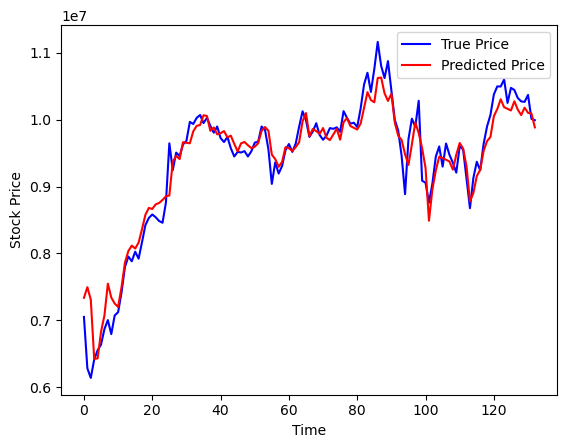

Directional Accuracy (DA) on Validation Set: 59.85%


In [8]:
# Model 6
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=32, validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
34/34 [==============================] - 1s 8ms/step - loss: 0.3280 - mae: 0.4473 - val_loss: 0.0017 - val_mae: 0.0323
Epoch 2/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1335 - mae: 0.2809 - val_loss: 0.0186 - val_mae: 0.1298
Epoch 3/200
34/34 [==============================] - 0s 4ms/step - loss: 0.1087 - mae: 0.2565 - val_loss: 0.0019 - val_mae: 0.0343
Epoch 4/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0696 - mae: 0.2033 - val_loss: 0.0035 - val_mae: 0.0514
Epoch 5/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0672 - mae: 0.1993 - val_loss: 0.0012 - val_mae: 0.0274
Epoch 6/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0472 - mae: 0.1686 - val_loss: 0.0011 - val_mae: 0.0259
Epoch 7/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0412 - mae: 0.1527 - val_loss: 0.0018 - val_mae: 0.0351
Epoch 8/200
34/34 [==============================] - 0s 5ms/step - loss: 0.0398 - m

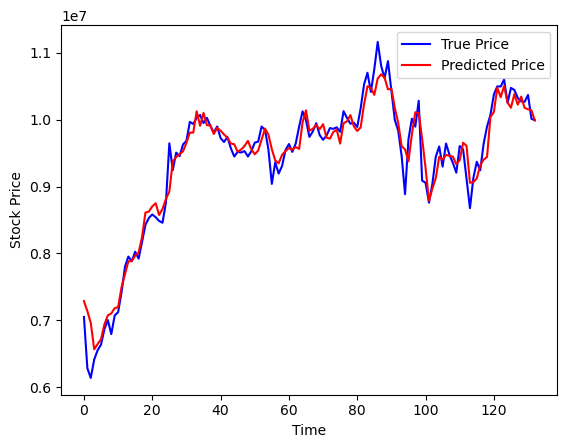

Directional Accuracy (DA) on Validation Set: 68.94%


In [9]:
# Model 7
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=16, validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 23ms/step - loss: 0.6502 - mae: 0.6345 - val_loss: 0.0176 - val_mae: 0.1245
Epoch 2/200
9/9 [==============================] - 0s 7ms/step - loss: 0.3772 - mae: 0.4841 - val_loss: 0.0100 - val_mae: 0.0823
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 0.2637 - mae: 0.4070 - val_loss: 0.0421 - val_mae: 0.1958
Epoch 4/200
9/9 [==============================] - 0s 7ms/step - loss: 0.2288 - mae: 0.3679 - val_loss: 0.0071 - val_mae: 0.0750
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1838 - mae: 0.3336 - val_loss: 0.0025 - val_mae: 0.0397
Epoch 6/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1392 - mae: 0.2982 - val_loss: 0.0045 - val_mae: 0.0532
Epoch 7/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1296 - mae: 0.2765 - val_loss: 0.0022 - val_mae: 0.0365
Epoch 8/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1076 - mae: 0.2589 - va

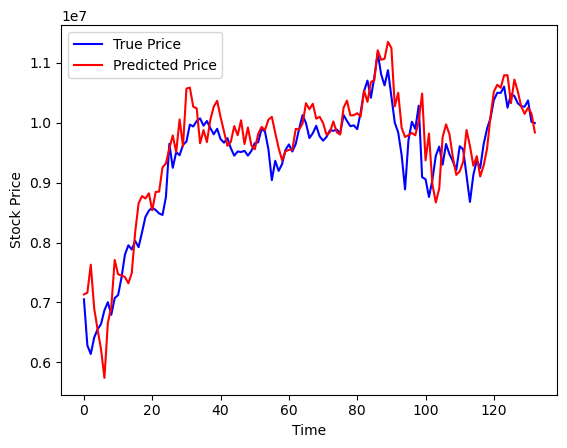

Directional Accuracy (DA) on Validation Set: 49.24%


In [10]:
# Model 8
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
5/5 [==============================] - 1s 40ms/step - loss: 0.3214 - mae: 0.4538 - val_loss: 0.0377 - val_mae: 0.1839
Epoch 2/200
5/5 [==============================] - 0s 10ms/step - loss: 0.2129 - mae: 0.3608 - val_loss: 0.0058 - val_mae: 0.0535
Epoch 3/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1582 - mae: 0.3106 - val_loss: 0.0403 - val_mae: 0.1903
Epoch 4/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1333 - mae: 0.2868 - val_loss: 0.0082 - val_mae: 0.0720
Epoch 5/200
5/5 [==============================] - 0s 10ms/step - loss: 0.1113 - mae: 0.2628 - val_loss: 0.0060 - val_mae: 0.0631
Epoch 6/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0981 - mae: 0.2448 - val_loss: 0.0027 - val_mae: 0.0380
Epoch 7/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0940 - mae: 0.2401 - val_loss: 0.0027 - val_mae: 0.0389
Epoch 8/200
5/5 [==============================] - 0s 10ms/step - loss: 0.0827 - mae: 0.22

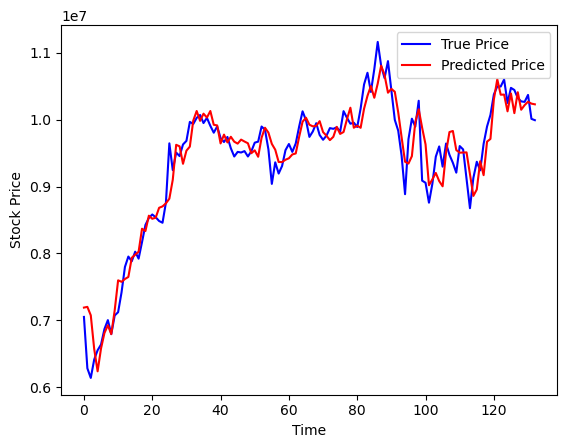

Directional Accuracy (DA) on Validation Set: 54.55%


In [11]:
# Model 9
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M))  # Output layer to predict 'M' days

# Compile the model
# Compile the model with MAE as a metric
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

early_stopping = EarlyStopping(
    monitor='val_loss',  
    patience=10,         
    restore_best_weights=True  
)

# Train the model
history = model.fit(X_train, y_train, epochs=200, 
                    batch_size=128, validation_data=(X_val, y_val),
                    callbacks=[early_stopping]
                    )

from sklearn.metrics import mean_absolute_error

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 25ms/step - loss: 0.9130 - mae: 0.7435 - val_loss: 0.2309 - val_mae: 0.4464
Epoch 2/200
9/9 [==============================] - 0s 9ms/step - loss: 0.5615 - mae: 0.5827 - val_loss: 0.0233 - val_mae: 0.0529
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 0.5494 - mae: 0.5841 - val_loss: 0.0213 - val_mae: 0.0386
Epoch 4/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4461 - mae: 0.5168 - val_loss: 0.0813 - val_mae: 0.2476
Epoch 5/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4244 - mae: 0.5013 - val_loss: 0.0389 - val_mae: 0.1391
Epoch 6/200
9/9 [==============================] - 0s 9ms/step - loss: 0.3401 - mae: 0.4565 - val_loss: 0.0196 - val_mae: 0.0397
Epoch 7/200
9/9 [==============================] - 0s 9ms/step - loss: 0.3361 - mae: 0.4621 - val_loss: 0.0211 - val_mae: 0.0682
Epoch 8/200
9/9 [==============================] - 0s 9ms/step - loss: 0.2537 - mae: 0.3850 - va

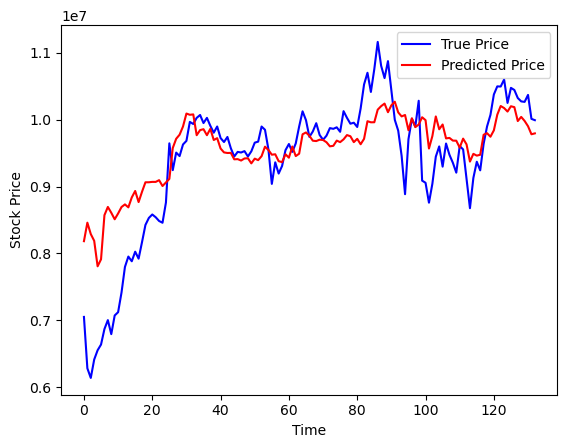

Directional Accuracy (DA) on Validation Set: 56.06%


In [12]:
# Model 10

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
                    recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False, recurrent_dropout=0.2))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.01)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()



# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 26ms/step - loss: 0.9072 - mae: 0.7657 - val_loss: 0.9588 - val_mae: 0.9741
Epoch 2/200
9/9 [==============================] - 0s 9ms/step - loss: 0.6228 - mae: 0.6425 - val_loss: 0.9425 - val_mae: 0.9667
Epoch 3/200
9/9 [==============================] - 0s 9ms/step - loss: 0.5601 - mae: 0.5929 - val_loss: 0.3059 - val_mae: 0.5473
Epoch 4/200
9/9 [==============================] - 0s 12ms/step - loss: 0.4954 - mae: 0.5581 - val_loss: 0.3608 - val_mae: 0.5957
Epoch 5/200
9/9 [==============================] - 0s 9ms/step - loss: 0.4682 - mae: 0.5525 - val_loss: 0.4498 - val_mae: 0.6660
Epoch 6/200
9/9 [==============================] - 0s 9ms/step - loss: 0.3484 - mae: 0.4788 - val_loss: 0.2258 - val_mae: 0.4692
Epoch 7/200
9/9 [==============================] - 0s 9ms/step - loss: 0.2865 - mae: 0.4232 - val_loss: 0.2142 - val_mae: 0.4577
Epoch 8/200
9/9 [==============================] - 0s 9ms/step - loss: 0.2889 - mae: 0.4194 - v

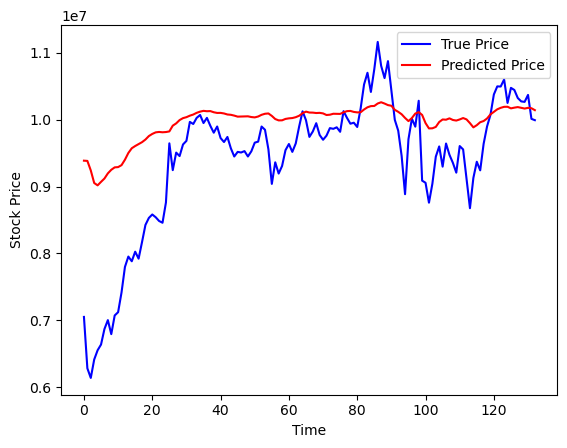

Directional Accuracy (DA) on Validation Set: 61.36%


In [13]:
# Model 11

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), 
                    recurrent_dropout=0.3))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False, recurrent_dropout=0.3))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.001)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), 
                    callbacks=[early_stopping])


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 23ms/step - loss: 0.3537 - mae: 0.4837 - val_loss: 0.0030 - val_mae: 0.0451
Epoch 2/200
9/9 [==============================] - 0s 7ms/step - loss: 0.2116 - mae: 0.3605 - val_loss: 0.0115 - val_mae: 0.0973
Epoch 3/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1698 - mae: 0.3227 - val_loss: 0.0485 - val_mae: 0.2136
Epoch 4/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1258 - mae: 0.2828 - val_loss: 0.0071 - val_mae: 0.0742
Epoch 5/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1002 - mae: 0.2449 - val_loss: 0.0035 - val_mae: 0.0467
Epoch 6/200
9/9 [==============================] - 0s 7ms/step - loss: 0.1000 - mae: 0.2430 - val_loss: 0.0026 - val_mae: 0.0400
Epoch 7/200
9/9 [==============================] - 0s 7ms/step - loss: 0.0810 - mae: 0.2189 - val_loss: 0.0050 - val_mae: 0.0590
Epoch 8/200
9/9 [==============================] - 0s 7ms/step - loss: 0.0691 - mae: 0.2019 - va

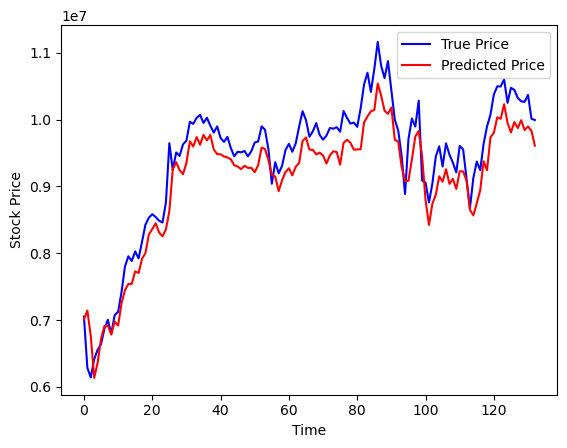

Directional Accuracy (DA) on Validation Set: 71.97%


In [14]:
# Model 12

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=50, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")


Epoch 1/200
9/9 [==============================] - 1s 26ms/step - loss: 0.6290 - mae: 0.6076 - val_loss: 0.0317 - val_mae: 0.1718
Epoch 2/200
9/9 [==============================] - 0s 11ms/step - loss: 0.2495 - mae: 0.3932 - val_loss: 0.0224 - val_mae: 0.1403
Epoch 3/200
9/9 [==============================] - 0s 11ms/step - loss: 0.2106 - mae: 0.3703 - val_loss: 0.0050 - val_mae: 0.0516
Epoch 4/200
9/9 [==============================] - 0s 14ms/step - loss: 0.1537 - mae: 0.3037 - val_loss: 0.0233 - val_mae: 0.1463
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1151 - mae: 0.2673 - val_loss: 0.0029 - val_mae: 0.0362
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0886 - mae: 0.2273 - val_loss: 0.0086 - val_mae: 0.0843
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0760 - mae: 0.2171 - val_loss: 0.0299 - val_mae: 0.1665
Epoch 8/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0663 - mae: 0.19

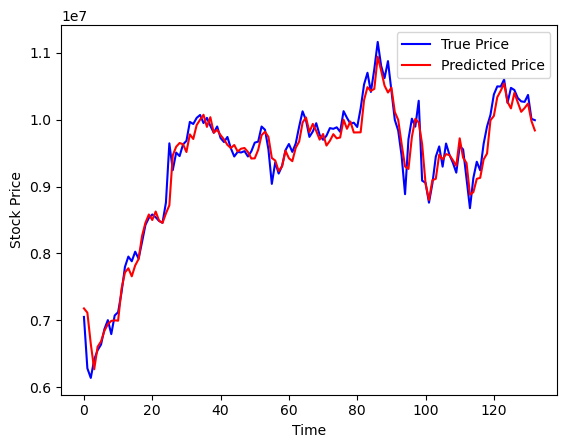

Directional Accuracy (DA) on Validation Set: 68.94%


In [15]:
# Model 13

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 32ms/step - loss: 0.6003 - mae: 0.6103 - val_loss: 0.4256 - val_mae: 0.6485
Epoch 2/200
9/9 [==============================] - 0s 19ms/step - loss: 0.2304 - mae: 0.3773 - val_loss: 0.0508 - val_mae: 0.2162
Epoch 3/200
9/9 [==============================] - 0s 19ms/step - loss: 0.1645 - mae: 0.3176 - val_loss: 0.0267 - val_mae: 0.1538
Epoch 4/200
9/9 [==============================] - 0s 19ms/step - loss: 0.1198 - mae: 0.2673 - val_loss: 0.0029 - val_mae: 0.0369
Epoch 5/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0979 - mae: 0.2451 - val_loss: 0.0074 - val_mae: 0.0757
Epoch 6/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0983 - mae: 0.2400 - val_loss: 0.0036 - val_mae: 0.0438
Epoch 7/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0780 - mae: 0.2171 - val_loss: 0.0258 - val_mae: 0.1526
Epoch 8/200
9/9 [==============================] - 0s 19ms/step - loss: 0.0683 - mae: 0.20

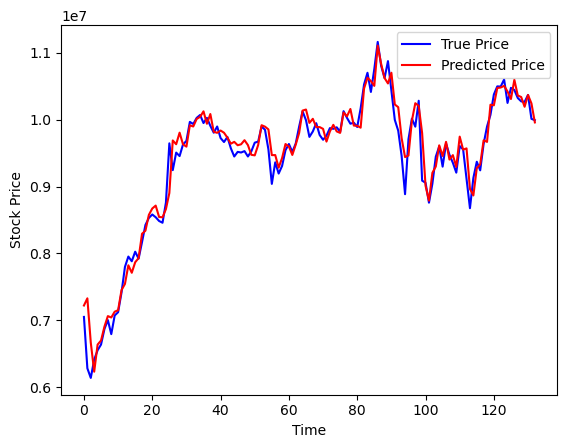

Directional Accuracy (DA) on Validation Set: 67.42%


In [16]:
# Model 14

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=150, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=150, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 26ms/step - loss: 0.3098 - mae: 0.4382 - val_loss: 0.0288 - val_mae: 0.1595
Epoch 2/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1474 - mae: 0.3032 - val_loss: 0.0025 - val_mae: 0.0377
Epoch 3/200
9/9 [==============================] - 0s 12ms/step - loss: 0.1002 - mae: 0.2495 - val_loss: 0.0277 - val_mae: 0.1591
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0760 - mae: 0.2086 - val_loss: 0.0024 - val_mae: 0.0361
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0636 - mae: 0.1938 - val_loss: 0.0094 - val_mae: 0.0878
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0549 - mae: 0.1804 - val_loss: 0.0035 - val_mae: 0.0485
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0488 - mae: 0.1700 - val_loss: 0.0020 - val_mae: 0.0342
Epoch 8/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0440 - mae: 0.16

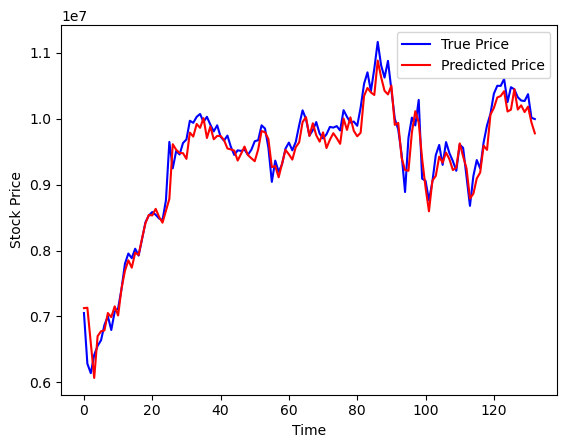

Directional Accuracy (DA) on Validation Set: 68.94%


In [17]:
# Model 15

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 26ms/step - loss: 0.4827 - mae: 0.5484 - val_loss: 0.0072 - val_mae: 0.0682
Epoch 2/200
9/9 [==============================] - 0s 11ms/step - loss: 0.2336 - mae: 0.3680 - val_loss: 0.0494 - val_mae: 0.2136
Epoch 3/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1932 - mae: 0.3420 - val_loss: 0.0196 - val_mae: 0.1260
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1391 - mae: 0.2866 - val_loss: 0.0066 - val_mae: 0.0704
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1137 - mae: 0.2663 - val_loss: 0.0047 - val_mae: 0.0538
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1042 - mae: 0.2477 - val_loss: 0.0026 - val_mae: 0.0366
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0839 - mae: 0.2294 - val_loss: 0.0064 - val_mae: 0.0716
Epoch 8/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0845 - mae: 0.22

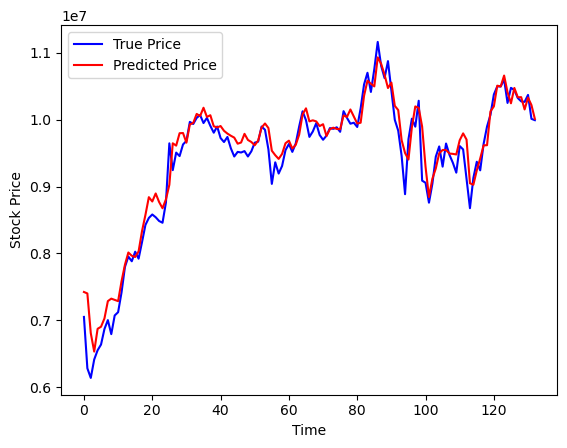

Directional Accuracy (DA) on Validation Set: 63.64%


In [18]:
# Model 16

from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.4))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100 

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 27ms/step - loss: 0.4139 - mae: 0.5052 - val_loss: 0.0816 - val_mae: 0.2831
Epoch 2/200
9/9 [==============================] - 0s 14ms/step - loss: 0.2044 - mae: 0.3566 - val_loss: 0.0032 - val_mae: 0.0465
Epoch 3/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1567 - mae: 0.3011 - val_loss: 0.0047 - val_mae: 0.0604
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1061 - mae: 0.2583 - val_loss: 0.0086 - val_mae: 0.0849
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1162 - mae: 0.2672 - val_loss: 0.0027 - val_mae: 0.0388
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0866 - mae: 0.2260 - val_loss: 0.0019 - val_mae: 0.0346
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0621 - mae: 0.1975 - val_loss: 0.0032 - val_mae: 0.0486
Epoch 8/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0614 - mae: 0.19

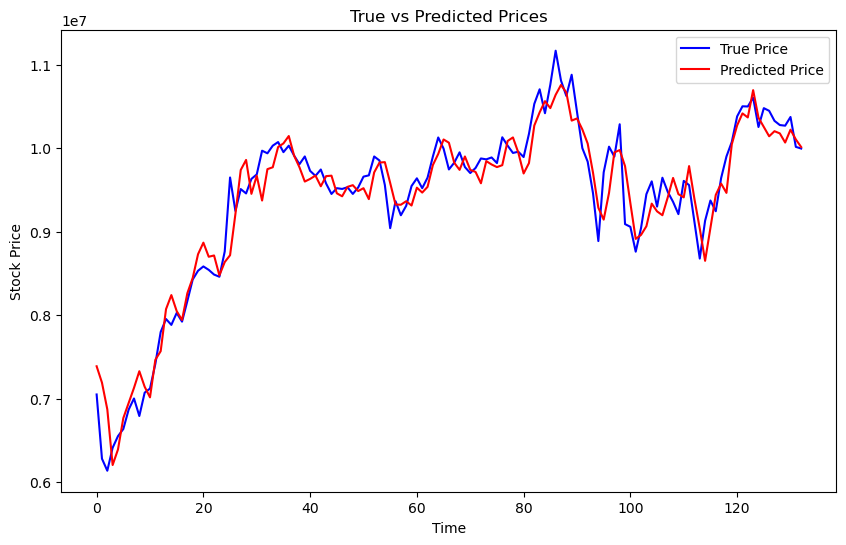

Directional Accuracy (DA) on Validation Set: 58.33%


In [19]:
# Model 17

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error
import numpy as np
import matplotlib.pyplot as plt

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.00001))) 

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('True vs Predicted Prices')
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")


Epoch 1/200
9/9 [==============================] - 1s 27ms/step - loss: 0.3500 - mae: 0.4547 - val_loss: 0.0314 - val_mae: 0.1588
Epoch 2/200
9/9 [==============================] - 0s 12ms/step - loss: 0.2331 - mae: 0.3862 - val_loss: 0.0374 - val_mae: 0.1808
Epoch 3/200
9/9 [==============================] - 0s 12ms/step - loss: 0.2264 - mae: 0.3782 - val_loss: 0.0212 - val_mae: 0.1288
Epoch 4/200
9/9 [==============================] - 0s 13ms/step - loss: 0.2129 - mae: 0.3532 - val_loss: 0.0080 - val_mae: 0.0778
Epoch 5/200
9/9 [==============================] - 0s 12ms/step - loss: 0.2007 - mae: 0.3541 - val_loss: 0.0043 - val_mae: 0.0472
Epoch 6/200
9/9 [==============================] - 0s 12ms/step - loss: 0.1722 - mae: 0.3234 - val_loss: 0.0108 - val_mae: 0.0849
Epoch 7/200
9/9 [==============================] - 0s 12ms/step - loss: 0.1641 - mae: 0.3123 - val_loss: 0.0151 - val_mae: 0.1068
Epoch 8/200
9/9 [==============================] - 0s 12ms/step - loss: 0.1507 - mae: 0.31

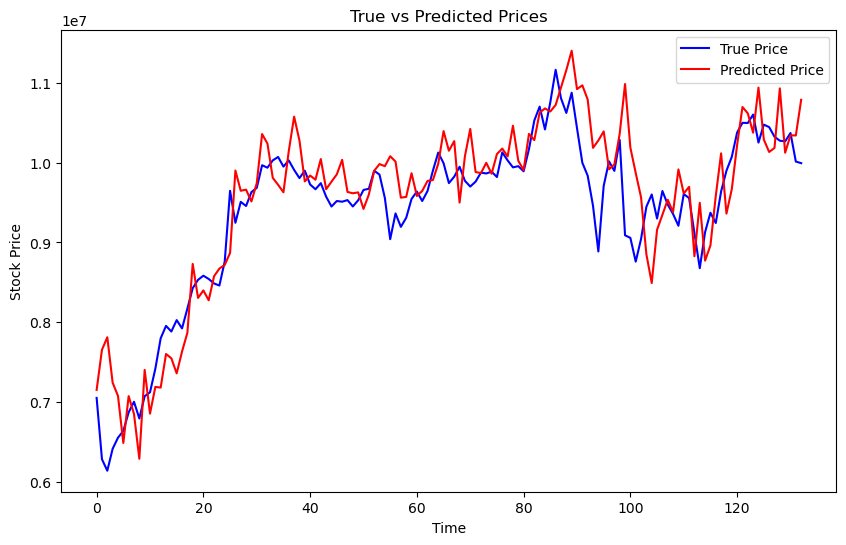

Directional Accuracy (DA) on Validation Set: 46.97%


In [21]:
from tensorflow.keras.optimizers import Adam

# Model 18

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.00001)))  

# Define a custom learning rate for the legacy Adam optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the legacy optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('True vs Predicted Prices')
plt.show()

# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")


Epoch 1/200
9/9 [==============================] - 1s 28ms/step - loss: 5.0075 - mae: 1.7330 - val_loss: 0.8197 - val_mae: 0.8950
Epoch 2/200
9/9 [==============================] - 0s 12ms/step - loss: 1.0909 - mae: 0.8365 - val_loss: 0.4570 - val_mae: 0.6724
Epoch 3/200
9/9 [==============================] - 0s 12ms/step - loss: 0.5412 - mae: 0.5823 - val_loss: 0.2175 - val_mae: 0.4621
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 0.4872 - mae: 0.5601 - val_loss: 0.1839 - val_mae: 0.4248
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.3930 - mae: 0.5002 - val_loss: 0.0937 - val_mae: 0.3011
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.4009 - mae: 0.5080 - val_loss: 0.0656 - val_mae: 0.2523
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.2794 - mae: 0.4204 - val_loss: 0.0573 - val_mae: 0.2360
Epoch 8/200
9/9 [==============================] - 0s 11ms/step - loss: 0.2568 - mae: 0.39

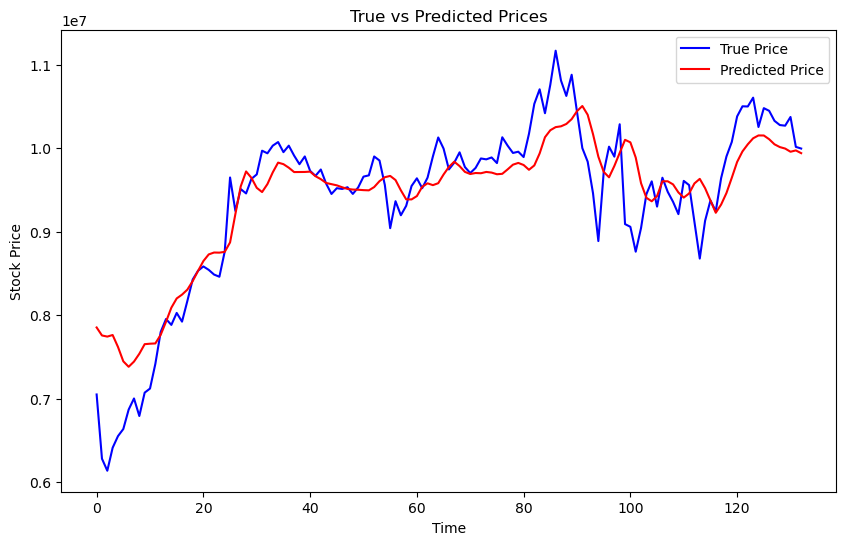

Directional Accuracy (DA) on Validation Set: 51.52%


In [22]:
# Model 19

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Define a custom learning rate for the legacy Adam optimizer
learning_rate = 0.01
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the legacy optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('True vs Predicted Prices')
plt.show()

# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")


Epoch 1/200
9/9 [==============================] - 1s 39ms/step - loss: 0.5092 - mae: 0.5738 - val_loss: 0.0148 - val_mae: 0.0941
Epoch 2/200
9/9 [==============================] - 0s 18ms/step - loss: 0.4350 - mae: 0.5213 - val_loss: 0.0174 - val_mae: 0.1171
Epoch 3/200
9/9 [==============================] - 0s 19ms/step - loss: 0.4320 - mae: 0.5218 - val_loss: 0.0627 - val_mae: 0.2412
Epoch 4/200
9/9 [==============================] - 0s 18ms/step - loss: 0.4079 - mae: 0.5032 - val_loss: 0.0051 - val_mae: 0.0498
Epoch 5/200
9/9 [==============================] - 0s 18ms/step - loss: 0.3760 - mae: 0.4909 - val_loss: 0.0047 - val_mae: 0.0477
Epoch 6/200
9/9 [==============================] - 0s 18ms/step - loss: 0.3555 - mae: 0.4847 - val_loss: 0.0045 - val_mae: 0.0464
Epoch 7/200
9/9 [==============================] - 0s 19ms/step - loss: 0.3578 - mae: 0.4749 - val_loss: 0.0158 - val_mae: 0.1100
Epoch 8/200
9/9 [==============================] - 0s 18ms/step - loss: 0.3258 - mae: 0.46

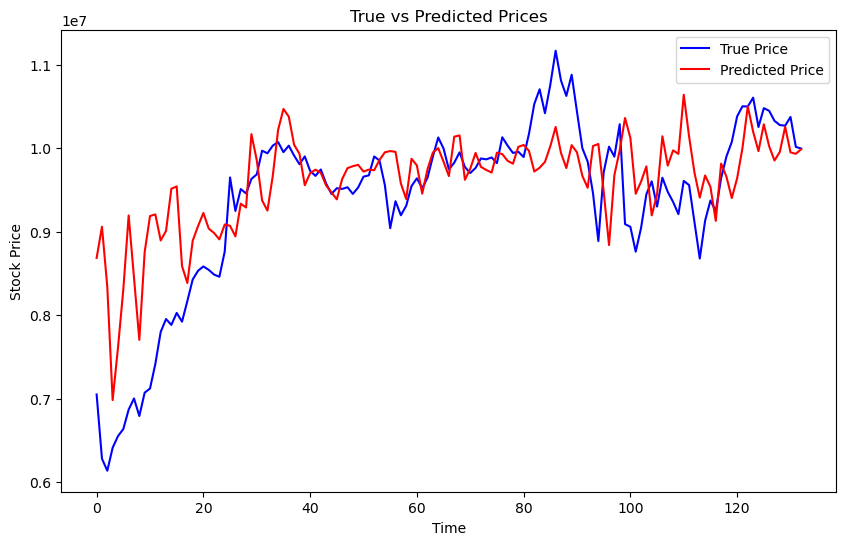

Directional Accuracy (DA) on Validation Set: 59.85%


In [23]:
# Model 20

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))
model.add(SimpleRNN(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=150, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Define a custom learning rate for the legacy Adam optimizer
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)

# Compile the model with the legacy optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val),
                    callbacks=[early_stopping])

# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.figure(figsize=(10, 6))
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('True vs Predicted Prices')
plt.show()

# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

Epoch 1/200
9/9 [==============================] - 1s 27ms/step - loss: 0.6171 - mae: 0.6212 - val_loss: 0.1231 - val_mae: 0.3417
Epoch 2/200
9/9 [==============================] - 0s 12ms/step - loss: 0.3293 - mae: 0.4563 - val_loss: 0.0067 - val_mae: 0.0637
Epoch 3/200
9/9 [==============================] - 0s 11ms/step - loss: 0.2217 - mae: 0.3712 - val_loss: 0.0053 - val_mae: 0.0542
Epoch 4/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1479 - mae: 0.3013 - val_loss: 0.0105 - val_mae: 0.0910
Epoch 5/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1316 - mae: 0.2887 - val_loss: 0.0056 - val_mae: 0.0615
Epoch 6/200
9/9 [==============================] - 0s 11ms/step - loss: 0.1206 - mae: 0.2680 - val_loss: 0.0077 - val_mae: 0.0785
Epoch 7/200
9/9 [==============================] - 0s 11ms/step - loss: 0.0908 - mae: 0.2324 - val_loss: 0.0025 - val_mae: 0.0362
Epoch 8/200
9/9 [==============================] - 0s 12ms/step - loss: 0.0700 - mae: 0.20

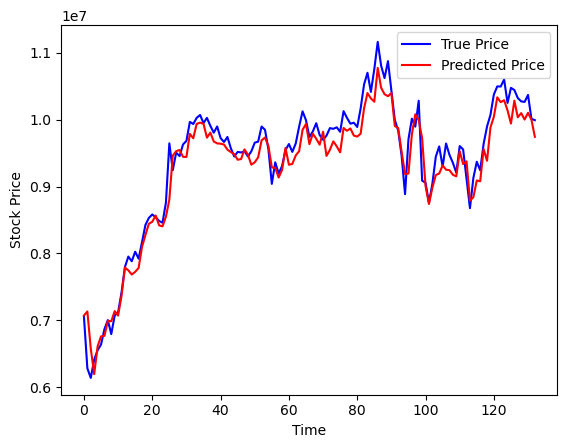

Directional Accuracy (DA) on Validation Set: 68.94%


In [24]:
# Model 13 - Retrain as best model found

# Vanilla RNN model modification with additional hyperparameters
model = Sequential()
model.add(SimpleRNN(units=100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.3))
model.add(SimpleRNN(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=M, kernel_regularizer=regularizers.l2(0.0001)))  

# Compile the model with a modified learning rate
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Early stopping callback to avoid overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val))


# Make predictions on the validation set
val_predictions = model.predict(X_val)

# Rescale the predictions and true values back to original values
val_predictions_expanded = np.zeros((val_predictions.shape[0], 5))
val_predictions_expanded[:, 3] = val_predictions.flatten()
val_predictions_original = scaler.inverse_transform(val_predictions_expanded)[:, 3]

y_val_expanded = np.zeros((y_val.shape[0], 5))
y_val_expanded[:, 3] = y_val.flatten()
y_val_original = scaler.inverse_transform(y_val_expanded)[:, 3]

# Calculate MAE on the rescaled validation set predictions
mae = mean_absolute_error(y_val_original, val_predictions_original)

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(y_val_original, val_predictions_original))

# Calculate R²
r2 = r2_score(y_val_original, val_predictions_original)

# Calculate MAPE
mape = mean_absolute_percentage_error(y_val_original, val_predictions_original) * 100  

# Print the metrics
print(f"Mean Absolute Error (MAE) on Validation Set: {mae}")
print(f"Root Mean Squared Error (RMSE) on Validation Set: {rmse}")
print(f"R² (Coefficient of Determination) on Validation Set: {r2}")
print(f"Mean Absolute Percentage Error (MAPE) on Validation Set: {mape:.2f}%")

# Plot true vs. predicted prices on the validation set
plt.plot(y_val_original, color='blue', label='True Price')
plt.plot(val_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


# Compute the actual and predicted direction changes
actual_direction = np.sign(np.diff(y_val_original))  
predicted_direction = np.sign(np.diff(val_predictions_original))

# Calculate Directional Accuracy
correct_directions = (actual_direction == predicted_direction)  
directional_accuracy = np.mean(correct_directions) * 100  

# Print Directional Accuracy
print(f"Directional Accuracy (DA) on Validation Set: {directional_accuracy:.2f}%")

1/1 [==============================] - 0s 100ms/step
Test Mean Absolute Error (MAE): 567354.7806132223
Test Root Mean Squared Error (RMSE): 600674.7761750408
Test R² (Coefficient of Determination): -1.1785847045262803
Test Mean Absolute Percentage Error (MAPE): 5.11%


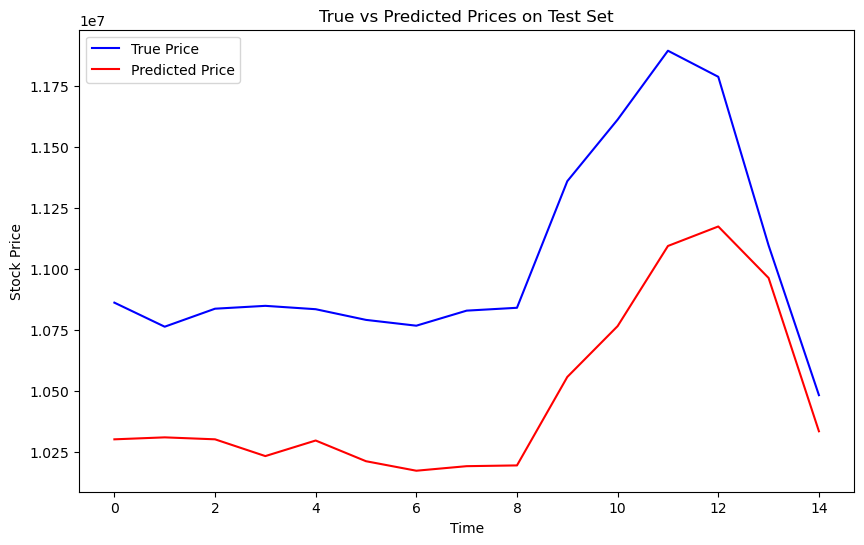

Directional Accuracy (DA) on Test Set: 64.29%


In [32]:
# Model 13 Predict on the test data
test_predictions = model.predict(X_test)

# Rescale the predictions and true values back to original values
test_predictions_expanded = np.zeros((test_predictions.shape[0], 5))
test_predictions_expanded[:, 3] = test_predictions.flatten()
test_predictions_original = scaler.inverse_transform(test_predictions_expanded)[:, 3]

y_test_expanded = np.zeros((y_test.shape[0], 5))
y_test_expanded[:, 3] = y_test.flatten()
y_test_original = scaler.inverse_transform(y_test_expanded)[:, 3]

# Calculate performance metrics for the test set
test_mae = mean_absolute_error(y_test_original, test_predictions_original)
test_rmse = np.sqrt(mean_squared_error(y_test_original, test_predictions_original))
test_r2 = r2_score(y_test_original, test_predictions_original)
test_mape = mean_absolute_percentage_error(y_test_original, test_predictions_original) * 100

# Print the test set metrics
print(f"Test Mean Absolute Error (MAE): {test_mae}")
print(f"Test Root Mean Squared Error (RMSE): {test_rmse}")
print(f"Test R² (Coefficient of Determination): {test_r2}")
print(f"Test Mean Absolute Percentage Error (MAPE): {test_mape:.2f}%")

# Plot true vs predicted prices on the test set
plt.figure(figsize=(10, 6))
plt.plot(y_test_original, color='blue', label='True Price')
plt.plot(test_predictions_original, color='red', label='Predicted Price')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('True vs Predicted Prices on Test Set')
plt.show()

# Compute the actual and predicted direction changes for the test set
test_actual_direction = np.sign(np.diff(y_test_original))  
test_predicted_direction = np.sign(np.diff(test_predictions_original))

# Calculate Directional Accuracy for the test set
test_correct_directions = (test_actual_direction == test_predicted_direction)  
test_directional_accuracy = np.mean(test_correct_directions) * 100  

# Print the Directional Accuracy for the test set
print(f"Directional Accuracy (DA) on Test Set: {test_directional_accuracy:.2f}%")
